# Exploratory Data Analysis

## Steps
1. Learn more about the Subject Domain
2. Use Common Heuristics to explore the data sample.  
2a. Heuristics for numerical data  
2b. Heuristics for categorical data  
3. Identify dirty data
4. Perform Bivariate Analysis
5. Create Data Hypotheses and test them

## Step 1.  Learn more about the Subject Domain

Project Goal : How may a school predict scores for students' O-level mathematics examination, so as to help the weaker students improve their mathematics ability?

This project deals with the domain of math scores of secondary school students in Singapore, which falls within a larger domain of the factors affecting students' academic performance.  There have been many studies on the larger domain around the world, and some findings are
* Performance on intelligence tests is correlated with school achievement
* Class attendance has a significant positive impaact on students' exam performance.
* Mixing students of different abilities in the same class could affect the students positively or negatively
* Study effort, age and a good match between the students' learning style and instructors' teaching style have a positive effect on students' performance.
* Competence in the language medium used to teach affects students' performance.
* Minimal gender differences in performance above ten years of age
* Students coming from low income families statistically perform worse on standardized tests
* There is a link between a smaller student:teacher ratio and how well those classes do


### Data Documentation

The sample dataset comes with a data description.  I will make several assumptions about the data to confirm later with the subject matter expert

The following attributes are probably subjective assessments - increasing the variance depending on who is answering the question.

Collected by student response 
* number_of_siblings
* tuition
* hours_per_week
* sleep_time
* wake_time
* mode_of_transport
* bag_color

Collected by teacher(s) assessment 
* learning_style


The following attributes are probably objective assessments.  
Direct data
* direct_admission
* CCA 
* final_test 
* n_male 
* n_female
* gender

Calculated based on data 
* student_id
* age 
* attendance_rate


Other Assumptions
* CCA lists the Core CCA.  Students may have secondary CCAs.
* final_test is not the preliminary examination, which is known, rather than the actual O-level examination score.
* age is calculated based on the student's birthdate.
* there are probably gaps in the collection of attendance_rate and hours_per_week.



In [104]:
import math
import numpy as np
import scipy
import pandas as pd
import empiricaldist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


In [3]:
# Variables
raw_data_root = './data'
max_features_to_explore = 40
random_seed = 77



In [14]:
file_path = f'{raw_data_root}/pizza_v1.csv'
print(file_path)
raw_data = pd.read_csv(file_path)

raw_data.sample(10, random_state=random_seed)

./data/pizza_v1.csv


,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
82,D,"Rp90,000",12.0,mushrooms,meat_lovers,reguler,yes,yes
85,D,"Rp188,000",18.5,mushrooms,double_mix,jumbo,yes,yes
26,B,"Rp46,000",12.0,chicken,classic,medium,yes,no
5,A,"Rp140,000",18.5,black papper,american_favorite,jumbo,no,no
48,B,"Rp96,000",12.0,mushrooms,double_decker,medium,no,yes
41,B,"Rp119,000",17.0,mushrooms,new_york,XL,yes,no
53,C,"Rp78,000",12.0,meat,BBQ_meat_fiesta,medium,no,no
65,C,"Rp78,000",12.0,vegetables,gournet_greek,medium,no,no
76,C,"Rp32,000",8.5,tuna,neptune_tuna,small,yes,no
73,C,"Rp35,000",8.5,beef,american_classic,small,yes,no


In [85]:
raw_data['price'] = raw_data['price_rupiah'].apply(lambda x :
    int( x[2:].replace(',', ''))
)
raw_data.sample(10)

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese,price
120,E,"Rp72,000",14.0,mozzarella,classic,large,yes,yes,72000
70,C,"Rp39,000",8.5,vegetables,thai_veggie,small,no,yes,39000
36,B,"Rp123,000",12.0,smoked beef,double_decker,medium,yes,yes,123000
52,C,"Rp44,000",8.5,meat,BBQ_meat_fiesta,small,yes,no,44000
106,E,"Rp31,000",8.5,mushrooms,classic,small,yes,yes,31000
8,A,"Rp90,000",12.0,mushrooms,american_favorite,reguler,yes,no,90000
81,D,"Rp70,000",8.0,chicken,meat_lovers,reguler,yes,yes,70000
95,D,"Rp31,000",8.5,mushrooms,classic,small,yes,yes,31000
28,B,"Rp49,000",12.0,mozzarella,crunchy,medium,no,no,49000
101,E,"Rp46,000",12.0,chicken,classic,medium,yes,no,46000


In Step 1, I have learnt about this subject domain, and I have made some observations on the data sample.
There is good reason to continue the experiment as I have quite a few columns that might be proxies of data that have found to be correlated to examination performance.  
* number_of_siblings, CCA - emotional intelligence
* direct_admission - IQ
* learning_style
* mode_of_transport - wealth
* n_male, n_female - class size
* hours_per_week, tuition, sleep_time, wake_time - study effort
* attendance_rate  

The dataset also should have sufficient rows.  Let us carry on.

In [86]:
target_col = 'price'
X_data = raw_data.drop(target_col, axis=1)
y_data = raw_data[target_col]
X_train, X_val, y_train, y_val = train_test_split( X_data, y_data, random_state=random_seed)

In [90]:
type(y_train)
columns_to_drop = ['price_rupiah']
Train = X_train.copy().drop(columns_to_drop, axis=1)
Train['target'] = y_train

## Step 2. Use commmon heuristics to explore the data sample

We can use some tools in pandas to quickly explore the data, and in matplotlib / seaborn to quickly graph the data.

In [91]:
print(f'Shape (rows, cols): {Train.shape}')
Train.info()


Shape (rows, cols): (96, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 108 to 95
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       96 non-null     object 
 1   diameter      96 non-null     float64
 2   topping       96 non-null     object 
 3   variant       96 non-null     object 
 4   size          96 non-null     object 
 5   extra_sauce   96 non-null     object 
 6   extra_cheese  96 non-null     object 
 7   target        96 non-null     int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 6.8+ KB


In [92]:
Train.sample(10, random_state = random_seed).T

,112,17,3,128,100,25,21,83,15,12
company,E,A,A,E,E,B,A,D,A,A
diameter,8.5,8.0,14.0,12.0,8.5,8.5,18.5,12.0,18.5,8.0
topping,chicken,chicken,smoked beef,meat,mozzarella,mozzarella,mushrooms,mozzarella,mozzarella,smoked beef
variant,classic,meat_lovers,double_signature,BBQ_meat_fiesta,classic,classic,double_mix,meat_lovers,meat_lovers,super_supreme
size,small,reguler,reguler,medium,small,small,jumbo,reguler,jumbo,reguler
extra_sauce,no,yes,yes,no,yes,yes,yes,yes,no,yes
extra_cheese,yes,yes,no,no,no,no,yes,yes,yes,yes
target,33000,70000,155000,78000,23500,23500,188000,90000,140000,70000


## Heuristics for Numerical data

In [93]:
df_num = Train.select_dtypes(include = ['float64', 'int64'])

**Skewed columns**
target    1.455054
dtype: float64


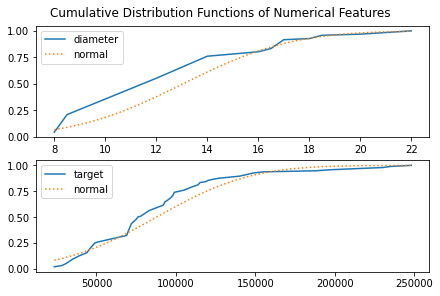

In [135]:
batch = 1
# from math import abs

def get_skew_columns(df_in, max_skew = 0.75) :
    skew_columns = df_in.skew().sort_values(ascending = False)
    skew_columns = skew_columns.loc[ lambda val: abs(val) > max_skew ]
    if len(skew_columns) > 0 :
        print('**Skewed columns**')
        print(skew_columns)
        
def plot_histogram(df_in, batch = 1, max_skew = 0.75) :
    df_small = df_in.iloc[:, (batch-1)*10 : batch*10]
    df_small.hist(
        figsize=(16, 5), layout=(2, 5), bins=20, xlabelsize=8, ylabelsize=8)
    print(f'Batch {batch} of 10 histograms')
    skew_columns = get_skew_columns(df_small, max_skew)
    
def plot_cdf(df_in, batch = 1, max_skew = 0.75) :
    df_small = df_in.iloc[:, (batch-1)*10 : batch*10]
    get_skew_columns(df_in)


    num_charts = min(len(df_small.columns), 10)
    _, ax = plt.subplots(num_charts, constrained_layout=True)
    plt.suptitle('Cumulative Distribution Functions of Numerical Features')
    for i, col in enumerate(df_small.columns) :
        series = df_small[col]
        cdf = empiricaldist.Cdf.from_seq(series)
        ax[i].plot(cdf, label=col)

        norm_dist = scipy.stats.norm(np.mean(series), np.std(series))
        xs = np.linspace(np.min(series), np.max(series))        
        ax[i].plot(xs, norm_dist.cdf(xs), ':', label='normal')
        ax[i].legend()

plot_cdf(df_num, batch = 1)

n_female, age and attendance_rate features may need to be normalized.



In [19]:
some_categorical_columns = []
df_num_features = df_num.drop(some_categorical_columns, axis=1)
# df_num_features = df_num
print('None of the numeric features looks like categorical data')

None of the numeric features looks like categorical data


it is unlikely that the age is below 10, assume data error.
Domain knowledge allows for outliers for n_male, n_female, attendance_rate.


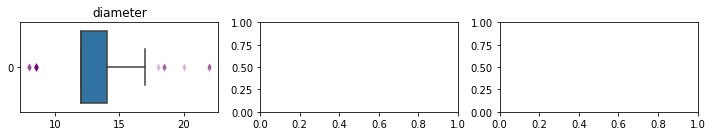

In [20]:
def plot_numerical_boxplots(df_plot) :
    num_features = len(df_plot.columns)
    if num_features > max_features_to_explore :
        print('Large number of features:', num_features)
        num_features = 40
    num_rows = math.ceil(num_features / 3)
    fig, axes = plt.subplots(num_rows, 3, figsize=(10, 2 * num_rows))

    color=iter( plt.cm.tab20( np.linspace(0,1, num_features)))
    for i, ax in enumerate(fig.axes):
        if i < len(df_plot.columns):
            column_name = df_plot.columns[i]
            ax.set_title(column_name)

            data = df_plot[column_name]
            if is_power_scale(data)  : # to do how to derive power scale
                data = np.log(data)
                ax.set_title(f'log ({column_name})', )
            sns.boxplot(ax=ax, data=data.to_numpy(), orient='h', color=next(color), flierprops=dict(
                markerfacecolor='purple', markeredgecolor='none', alpha=.3
            ),)

    fig.tight_layout()

def is_power_scale(data) :
    return (data.quantile(0.75) + 1) > 4 * (data.quantile(0.25) + 1)

plot_numerical_boxplots(df_num_features)

print('it is unlikely that the age is below 10, assume data error.')
print('Domain knowledge allows for outliers for n_male, n_female, attendance_rate.')


In [21]:
print('Seems like there are missing values for attendance_rate.')
df_num_features.describe()

Seems like there are missing values for attendance_rate.


,diameter
count,96.000000
mean,13.052083
std,3.379878
min,8.000000
25%,12.000000
50%,12.000000
75%,14.000000
max,22.000000


ValueError: could not convert string to float: 'Rp93,000'

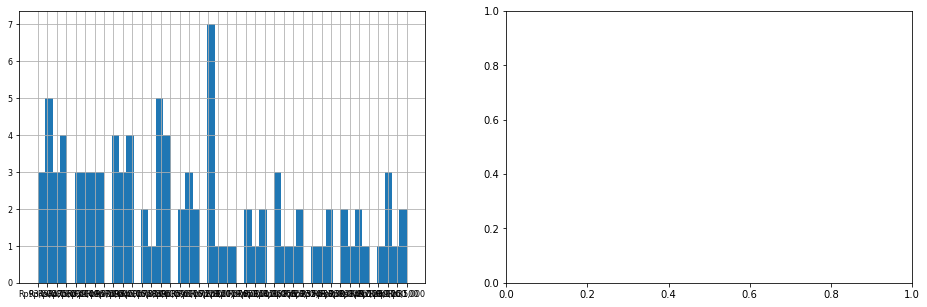

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
y_train.hist(bins=50, xlabelsize=8, ylabelsize=8, ax=axes[0])
sns.boxplot(ax=axes[1], data=y_train.to_numpy(), orient='h', 
    flierprops=dict(markerfacecolor='purple', markeredgecolor='none', alpha=.3),)

print('The distribution of the target column seems normal.  However, there may be missing values.')
y_train.describe()

### Heuristics to explore Categorical Data

In [138]:
object_columns = Train.select_dtypes(include = ['O']).columns 
categorical_columns = [*some_categorical_columns, *object_columns] 
df_cat_features = Train[ categorical_columns ]

['A' 'B' 'C' 'D' 'E']
['beef' 'black papper' 'chicken' 'meat' 'mozzarella' 'mushrooms' 'onion'
 'papperoni' 'sausage' 'smoked beef' 'tuna' 'vegetables']
['BBQ_meat_fiesta' 'BBQ_sausage' 'american_classic' 'american_favorite'
 'classic' 'crunchy' 'double_decker' 'double_mix' 'double_signature'
 'extravaganza' 'gournet_greek' 'italian_veggie' 'meat_eater'
 'meat_lovers' 'neptune_tuna' 'new_york' 'spicy tuna' 'spicy_tuna'
 'super_supreme' 'thai_veggie']
['XL' 'jumbo' 'large' 'medium' 'reguler' 'small']
['no' 'yes']
['no' 'yes']
student_id is unlikely to be a useful category for prediction.
student_id should not have count 2.
sleep_time may need feature engineering.
tuition and CCA have values that need to be combined


C:\Users\colin\AppData\Local\Temp/ipykernel_11012/1264930096.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew_columns = df_in.skew().sort_values(ascending = False)


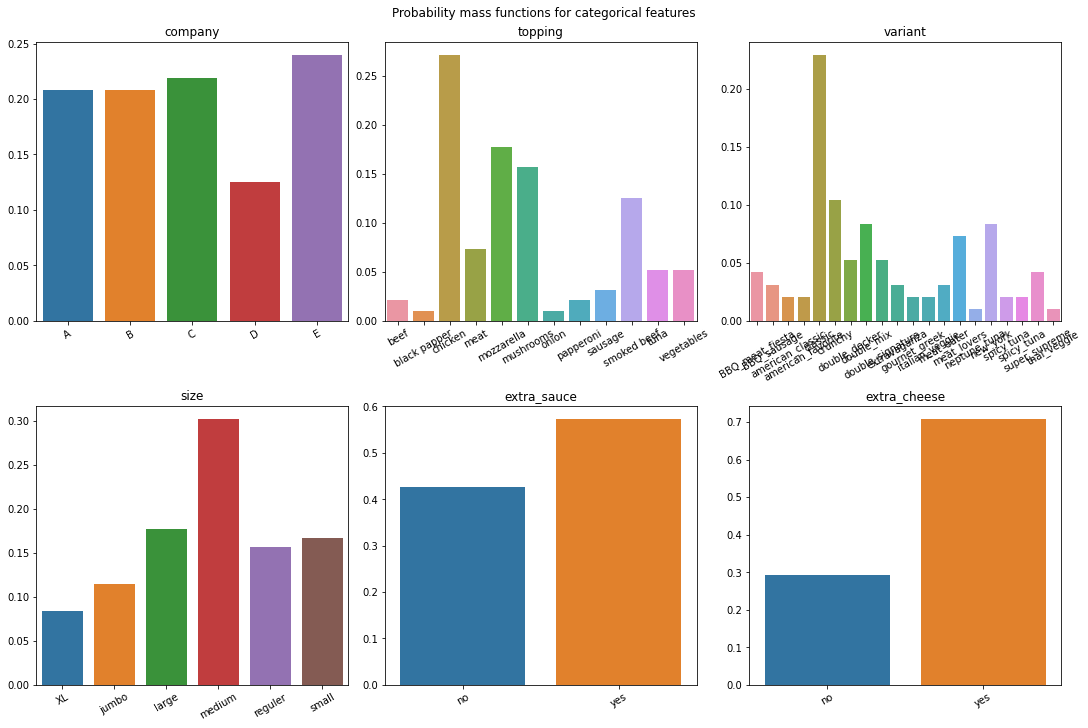

In [166]:

def plot_pmf(series, ax) :
    pmf = empiricaldist.Pmf.from_seq(series)
    # pmf.normalize()
    print(pmf.qs)
    # ax.bar(pmf.qs, pmf.ps)
    sns.barplot(x=pmf.qs, y=pmf.ps, ax=ax)
    ax.xaxis.set_tick_params(rotation=30)

# def count_plot(df_plot, column_name) :
#     value_counts = df_plot[column_name].value_counts()
#     order = value_counts.iloc[:max_categories].index
#     sns.countplot(x=column_name, alpha=0.7, data=df_plot, ax=ax, order=order)
#     plot_pmf(df_plot[column_name], ax)

#     ax.xaxis.set_major_locator(mpl.ticker.FixedLocator( ax.get_xticks().tolist()))
#     xlabels = [i.get_text()[:max_label_length] + '..'
#         if len(i.get_text()) > max_label_length 
#         else i.get_text()
#         for i in ax.xaxis.get_majorticklabels()]
#     ax.set_xticklabels(xlabels, rotation=45)
#     ax.xaxis.set_label_position('top')
#     if (len(value_counts) > max_categories) :
#         ax.xaxis.set_label_text(f'{column_name} (Top {max_categories})')
#         spread_features[column_name] = len(value_counts)

def plot_categorical_histograms(df_plot, max_categories=11, max_label_length=10,
                               max_skew = 0.75) :
    num_features = len(df_plot.columns)
    if num_features > max_features_to_explore :
        num_features = max_features_to_explore
    num_rows = math.ceil( num_features/ 3)
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows), constrained_layout=True)
    plt.suptitle('Probability mass functions for categorical features')

    spread_features = {}
    for i, ax in enumerate(fig.axes):
        if i < len(df_plot.columns):
            column_name = df_plot.columns[i]
            plot_pmf(df_plot[column_name], ax)
            ax.set_title(column_name)

    skew_columns = get_skew_columns(df_plot, max_skew)
    
    if spread_features :
        print('**Features with big spread**')
        for feature_name in spread_features :
            print(feature_name, spread_features[feature_name], 'categories')

plot_categorical_histograms(df_cat_features)

print('student_id is unlikely to be a useful category for prediction.')
print('student_id should not have count 2.')
print('sleep_time may need feature engineering.')
print('tuition and CCA have values that need to be combined')




At the end of step 2, I am much clearer on what the different data columns are like.  
I only identified one column to drop, student_id.  
But this information will lead to more exploration for dirty data and for feature engineering.  
Let's continue.


## Step 3. Identify Dirty Data

In [32]:
def show_duplicates(df) :
    return df[df.duplicated(keep=False)]
duplicates = show_duplicates(X_train)
print(f'*{len(duplicates)/2 * 100 / len(X_train):.3}% of data has duplicates.*')
duplicates

*2.08% of data has duplicates.*


,company,diameter,topping,variant,size,extra_sauce,extra_cheese
122,E,17.0,chicken,new_york,XL,no,yes
104,E,17.0,chicken,new_york,XL,no,yes
29,B,17.0,chicken,new_york,XL,no,yes
47,B,17.0,chicken,new_york,XL,no,yes


In [33]:
def summarize_missing_values(df_in) :
    total_rows = len(df_in)
    arr_missing_counts = []
    for column in df_in :
        column_values = df_in[column].tolist()
        null_value_count = len([x for x in column_values if str(x) == 'nan'])
        zero_value_count = len([x for x in column_values if x == 0])

        if (null_value_count > 0 or zero_value_count > 0) :
            percent = (null_value_count + zero_value_count) / total_rows * 100
            arr_missing_counts.append([
                column, 
                null_value_count, 
                zero_value_count, 
                f'{percent:06.3f}%',
            ])
    return pd.DataFrame(arr_missing_counts, 
        columns = ['Column', 'Null values', 'Zero values', 'Percentage'])

df_missing = summarize_missing_values(X_train)
print('Zero values make sense for number_of_siblings, n_female, n_male, hours_per_week')
df_missing.sort_values(by=['Percentage'], ascending=False)


Zero values make sense for number_of_siblings, n_female, n_male, hours_per_week


,Column,Null values,Zero values,Percentage


In [35]:
print('*Why are there Null values for attendance_rate?*')
print('The rest of the data looks normal, it could be a collection error. ')

X_train[X_train['attendance_rate'].isnull()].sample(10).T


*Why are there Null values for attendance_rate?*
The rest of the data looks normal, it could be a collection error. 


KeyError: 'attendance_rate'

In [ ]:
print('Seems like there really are students who study 0 hours per week')
X_train[X_train['hours_per_week'] == 0].sample(5).T


Seems like there really are students who study 0 hours per week


index,527,6078,12603,7175,15049
number_of_siblings,1,1,1,1,1
direct_admission,No,No,No,Yes,No
CCA,Arts,Clubs,Sports,Arts,Sports
learning_style,Auditory,Auditory,Auditory,Auditory,Auditory
student_id,ZQI6PZ,WT5VCR,L2X5DW,RM1DEA,9EFFRT
gender,Male,Female,Female,Male,Male
tuition,Yes,No,No,Yes,No
n_male,11,2,25,16,25
n_female,18,22,5,1,0
age,16,16,15,15,15


In [ ]:
printmd('*Why are there small values for age?*')
print('The rest of the data looks normal, it could be a collection error. ')

X_train[X_train['age'] < 15].sample(5).T

*Why are there small values for age?*

The rest of the data looks normal, it could be a collection error. 


index,3860,5206,13652,15542,10603
number_of_siblings,1,1,0,1,0
direct_admission,Yes,Yes,No,Yes,Yes
CCA,Arts,Sports,None,Sports,Arts
learning_style,Auditory,Auditory,Auditory,Visual,Auditory
student_id,TJCJSE,EBP0OV,AY9ALG,G07DJM,YAKDPY
gender,Male,Male,Male,Male,Male
tuition,Yes,Yes,No,No,Yes
n_male,17,12,19,25,12
n_female,4,5,2,2,3
age,5,6,6,6,5


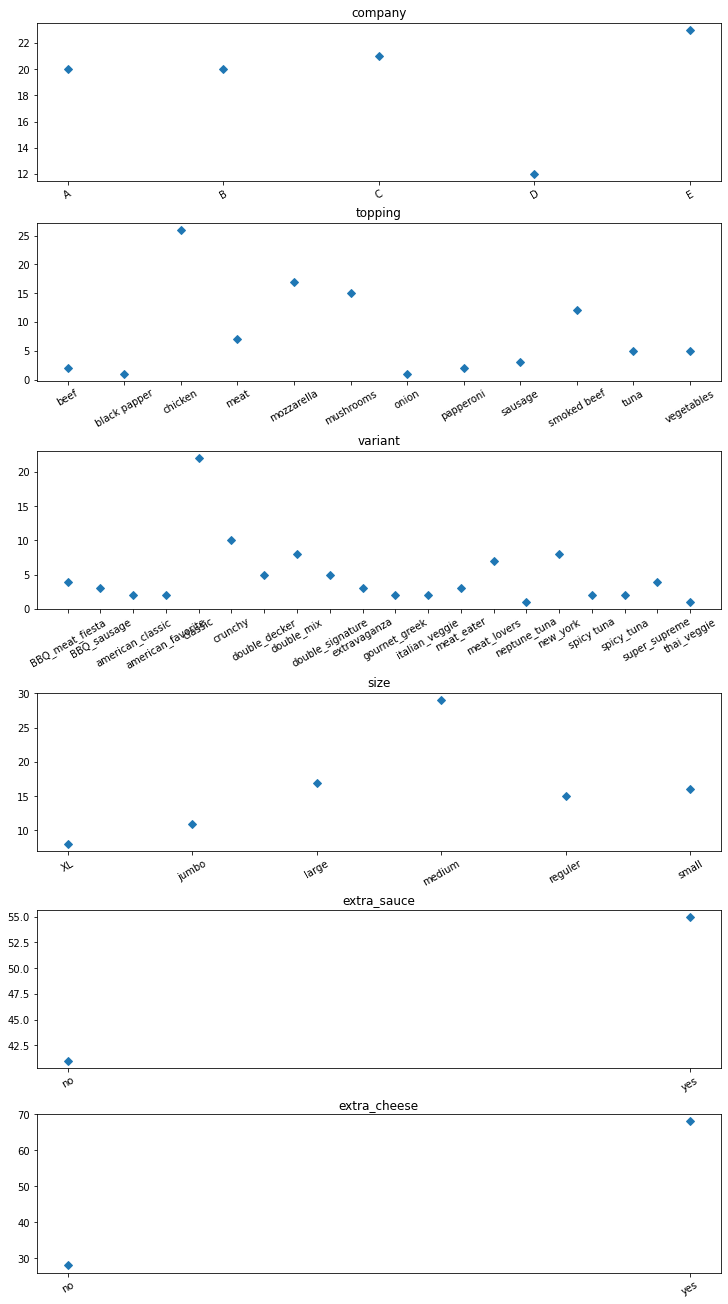

In [68]:

# Ensure the values are not misspelt.
num_rows = len(df_cat_features.columns)
fig, ax = plt.subplots( 
    num_rows, figsize=(10, 3*num_rows), constrained_layout=True,
)

for i, column in enumerate(df_cat_features.columns) :
    value_counts = df_cat_features[column].value_counts(dropna = False)
    value_counts = value_counts.sort_index()
    ax[i].plot(
        value_counts, marker = 'D', linestyle='',
    )
    ax[i].set_title(column)
    ax[i].xaxis.set_tick_params(rotation=30)

In [36]:
def show_nulls(df, column) :
    return df.loc[ pd.isna( df[ column]), :]

target_col = 'final_test'
rows_with_null_target = show_nulls(raw_data, target_col)
printmd(f'*{len(rows_with_null_target) * 100 / len(raw_data):.3}% of data has null values for the target column.*')

rows_with_null_target

KeyError: 'final_test'

In [ ]:
repaired_raw_data_1 = raw_data.drop( rows_with_null_target.index)
repaired_raw_data = repaired_raw_data_1.drop_duplicates()
printmd(f'*After repairing the data, we have {len(repaired_raw_data) * 100 / len(raw_data):.3}%' +
        f' of data left ({len(repaired_raw_data)} rows).*')
X_data_repaired = repaired_raw_data.drop(target_col, axis=1)
y_data_repaired = repaired_raw_data[target_col]
X_train_repaired, X_val_repaired, y_train_repaired, y_val_repaired = train_test_split( 
    X_data_repaired, y_data_repaired, random_state=random_seed)

*After repairing the data, we have 96.0% of data left (15267 rows).*

At the end of step 3, we see some duplicates, missing values and wrong values.  
These will need to be fixed in the ML Pipeline.

## Step 4. Bivariate Analysis
We look at relations between different columns.

In [ ]:
corr = df_num_features.corr() #Pearson correlation
tril_index = np.tril_indices_from(corr, k=-1)     # Simplify by emptying all the data below the diagonal
for coord in zip(*tril_index):
    corr.iloc[coord[0], coord[1]] = np.NaN     # Make the unused values NaNs
    
    
    

In [ ]:

def list_correlations(corr, strong_correlated_cutoff = 0.5) :
    df_corr_stack = (corr
                   .stack()     # Stack the data and convert to a data frame
                   .to_frame()
                   .reset_index()
                   .rename(columns={'level_0':'feature1',
                                    'level_1':'feature2',
                                    0:'correlation'}))
    df_corr_stack['abs_correlation'] = df_corr_stack.correlation.abs()
    df_corr_stack.sort_values('abs_correlation', ascending=False)
    df_large_corr_stack = df_corr_stack.loc[ np.where(
        (df_corr_stack['abs_correlation'] > strong_correlated_cutoff) &
        (df_corr_stack['abs_correlation'] != 1)
    )]
    if df_large_corr_stack.empty :
        printmd('*No strong correlation or anti-correlations*')
        return df_corr_stack
    else :
        return df_large_corr_stack

list_correlations(corr)

,feature1,feature2,correlation,abs_correlation
7,n_male,n_female,-0.793213,0.793213


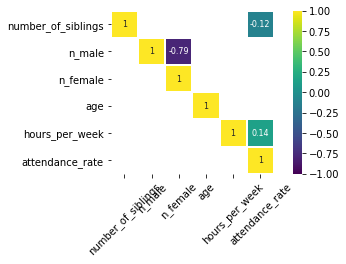

In [ ]:
def plot_corr(corr, cutoff = 0.4, max_features_to_explore=10) :
    num_features = len(corr.columns)
    if num_features > max_features_to_explore :
        num_features = max_features_to_explore
    fig_height = math.ceil(num_features / 2)
    plt.figure(figsize=(fig_height + 4, fig_height))
    g = sns.heatmap(
        corr[(corr >= cutoff ) | (corr <= -cutoff)], 
        cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
        annot=True, annot_kws={"size": 8}, square=True)
    tickLabels = plt.xticks(rotation=45)

plot_corr(corr, cutoff = 0.1)

In [ ]:
X_train.columns

Index(['number_of_siblings', 'direct_admission', 'CCA', 'learning_style',
       'student_id', 'gender', 'tuition', 'n_male', 'n_female', 'age',
       'hours_per_week', 'attendance_rate', 'sleep_time', 'wake_time',
       'mode_of_transport', 'bag_color'],
      dtype='object')

Pairplot generates some interesting observations.
Small anti-correlation between attendance rate and number of siblings
Small correlation between attendance rate and hours per week
Strong anti-correlation between n_male and n_female
Small polynomial relationship between max n_male and number_of_siblings
Small polynomial relationship between max n_female and number_of_siblings
age plots don't make sense - just ignore age < 10


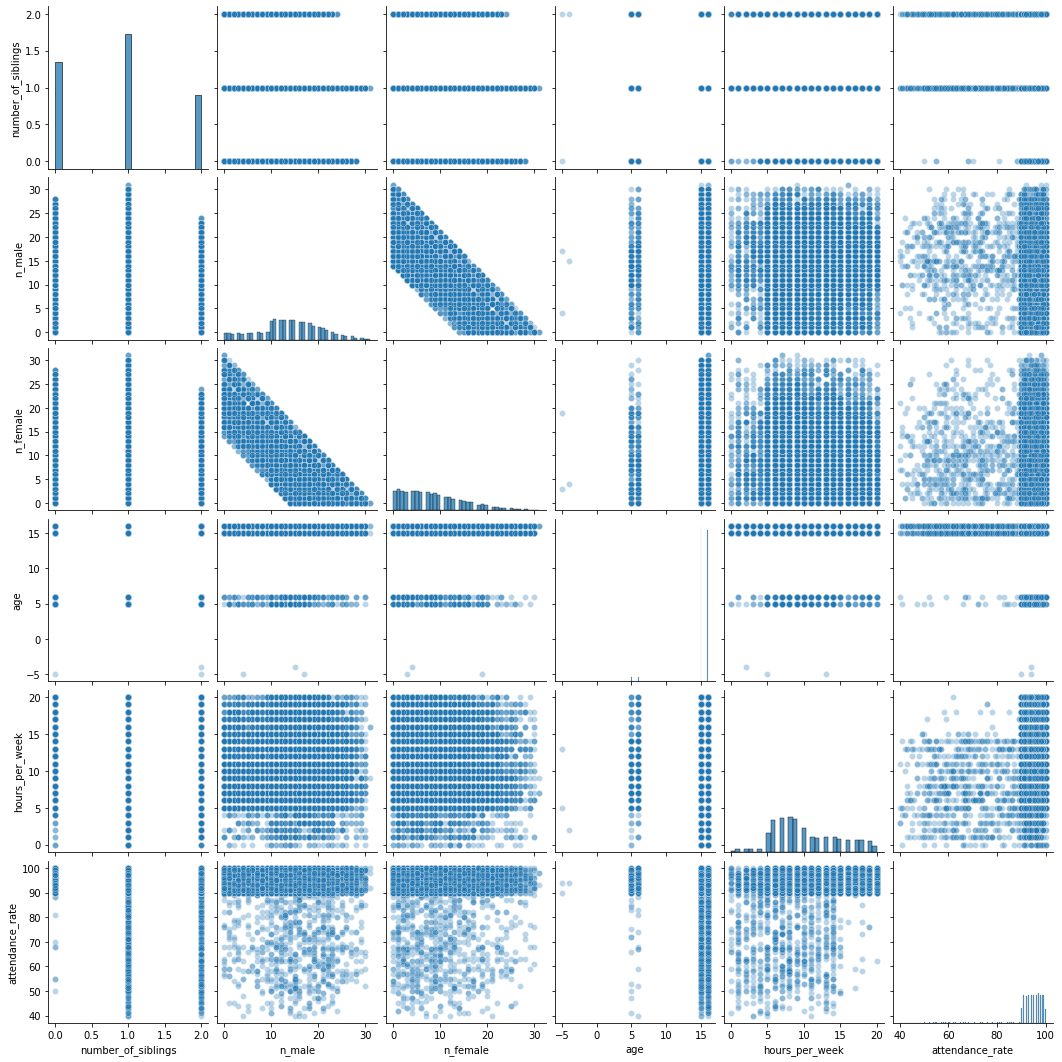

In [ ]:
features_to_analyse = ['number_of_siblings', 'n_male', 'n_female', 'age', 'hours_per_week', 'attendance_rate', ]
df_pairplot = X_train[features_to_analyse]
g = sns.pairplot(data=df_pairplot, plot_kws={'alpha':0.3})

print('Pairplot generates some interesting observations.')
print('Small anti-correlation between attendance rate and number of siblings')
print('Small correlation between attendance rate and hours per week')
print('Strong anti-correlation between n_male and n_female')
print('Small polynomial relationship between max n_male and number_of_siblings')
print('Small polynomial relationship between max n_female and number_of_siblings')
print("age plots don't make sense - just ignore age < 10")


There is no significants correlation for gender, age, wake time, and mode of transport with the target.
The rest of the columns have low degree of correlation.


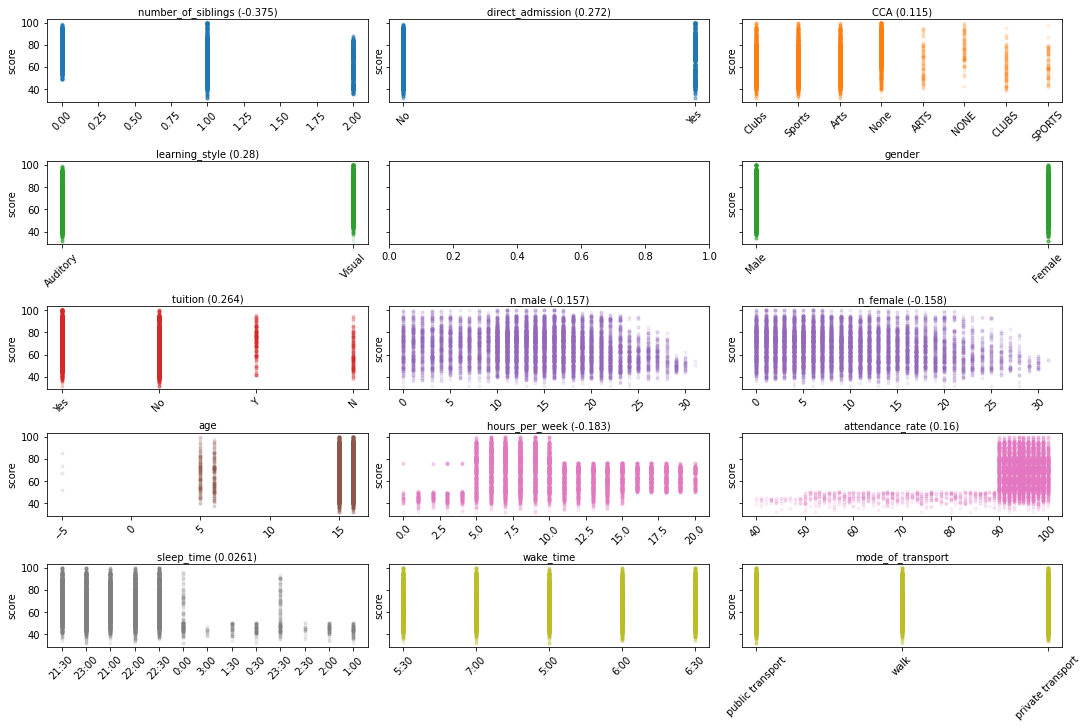

In [ ]:
from scipy.stats import spearmanr, kendalltau

def plot_columns_against_target(X_train, y_train) :
    columns = X_train.columns
    num_cols = 3
    num_rows = math.ceil( len(columns) // 3)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,10), constrained_layout=True, sharey=True)
    
    color=iter( plt.cm.tab10( np.linspace(0,1, len(columns))))
    for i, ax in enumerate(fig.axes) :
        column_name = X_train.columns[i]
        if i == 4: # student_id has many values
            continue
        
        x = X_train.iloc[:, i]
        ax.plot(x, y_train, '.', alpha=0.1, color=next(color))
        
        x2 = to_numeric_array(x)
        coeff, p = spearmanr(x2, y_train)
        if p < 0.1 :
            xlabel = f'{column_name} ({coeff:0.3})'
        else :
            xlabel = column_name
        
        ax.set_xlabel(xlabel)

        ax.set_ylabel('score')
        ax.xaxis.set_tick_params(rotation=45)
        ax.xaxis.set_label_position('top')

def to_numeric_array(x) :
    x2 = x.fillna(method='ffill')
    try:
        temp = float(x2[0])
        return x2
    except ValueError:
        result = OrdinalEncoder().fit_transform( x2.to_numpy().reshape(-1,1) ).flatten()
#         print(result[:5], result.shape)
        return result
        
plot_columns_against_target(X_train_repaired, y_train_repaired)
print('There is no significants correlation for gender, age, wake time, and mode of transport with the target.')
print ('The rest of the columns have low degree of correlation.')


At the end of step 4. Bivariate Analysis,  
I see that there is little strong correlation to take care of betweeh the possible source data features.  
There are some weak correlations between the possible features and the target column.    
I can try and narrow these down in the next section.


## Step 5. Create Data Hypotheses and test them

In [ ]:
df_query = X_train.copy()
df_query['score'] = y_train

*Hypothesis : Students with a lower attendance rate will do worse on the examination*

True.  Students with <90% attendance score less than 50 marks.


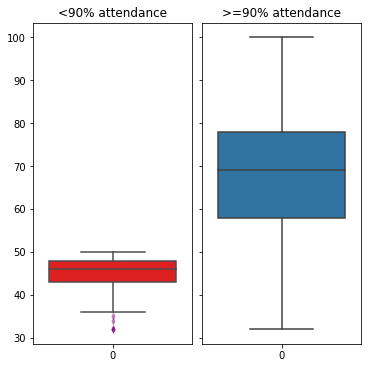

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(5,5), 
    sharex=True, sharey=True, constrained_layout=True
)

axes[0].set_title('<90% attendance')
df_investigate = df_query[df_query['attendance_rate'] < 90]
data = df_investigate['score']
sns.boxplot(ax=axes[0], data=data.to_numpy(), color='red',
    flierprops=dict(markerfacecolor='purple', markeredgecolor='none', alpha=.3
),)


axes[1].set_title('>=90% attendance')
df_investigate2 = df_query[df_query['attendance_rate'] >= 90]
sns.boxplot(ax=axes[1], data=df_investigate2['score'].to_numpy(), 
    flierprops=dict(markerfacecolor='purple', markeredgecolor='none', alpha=.3),
)

printmd('*Hypothesis : Students with a lower attendance rate will do worse on the examination*')
print('True.  Students with <90% attendance score less than 50 marks.')


*Hypothesis: Students with private transport will do better*

False.  There is no significant trend that students with private transport do better than others.

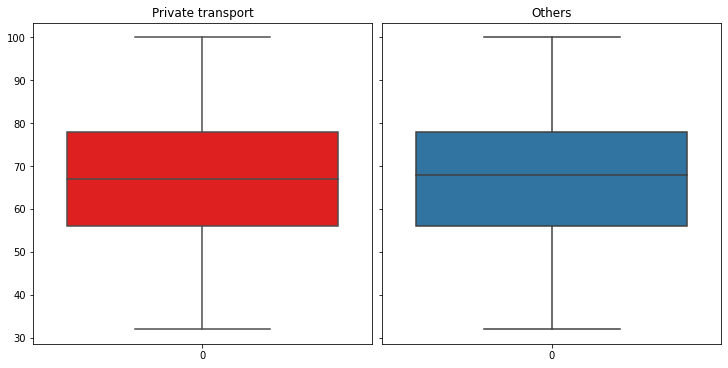

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5), 
     sharex=True, sharey=True, constrained_layout=True
)

ax = axes[0]
ax.set_title('Private transport')
df_investigate = df_query[df_query['mode_of_transport'] == 'private transport']
data = df_investigate['score'].to_numpy()
sns.boxplot(ax=axes[0], data=data, color = 'red', flierprops=dict(
    markerfacecolor='purple', markeredgecolor='none', alpha=.3
),)

ax = axes[1]
ax.set_title('Others')
df_investigate = df_query[df_query['mode_of_transport'] != 'private transport']
sns.boxplot(ax=axes[1], data=df_query['score'].to_numpy(), flierprops=dict(
    markerfacecolor='purple', markeredgecolor='none', alpha=.3
),)

printmd('*Hypothesis: Students with private transport will do better*')
printmd('False.  There is no significant trend that students with private transport do better than others.')

*Hypothesis: Students who sleep late will do worse*

True.  Students who sleep after 00:15 have lower scores.

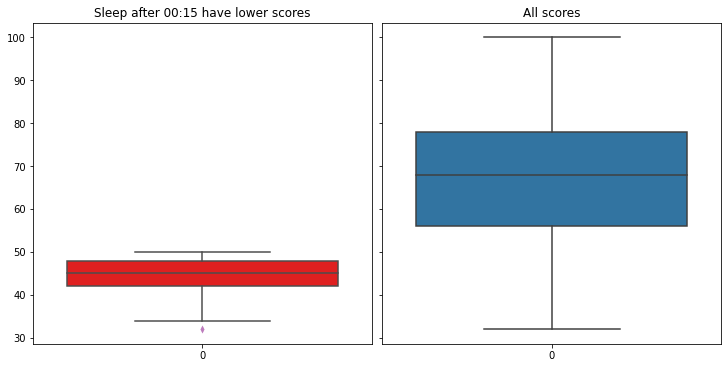

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5), 
 sharex=True, sharey=True, constrained_layout=True
)

ax=axes[0]
ax.set_title('Sleep after 00:15 have lower scores')
df_investigate = df_query[df_query[
    'sleep_time'].isin(['0:30', '1:00', '1:30', '2:00', '2:30', '3:00'])]
data = df_investigate['score'].to_numpy()
sns.boxplot(ax=axes[0], data=data, color='red',
    flierprops=dict(markerfacecolor='purple', markeredgecolor='none', alpha=.3),
)

ax=axes[1]
ax.set_title('All scores')
data = df_query['score'].to_numpy()
sns.boxplot(ax=axes[1], data=df_query['score'].to_numpy(), flierprops=dict(
    markerfacecolor='purple', markeredgecolor='none', alpha=.3
),)


printmd('*Hypothesis: Students who sleep late will do worse*')
printmd('True.  Students who sleep after 00:15 have lower scores.')

*Hypothesis: Student who are in Clubs CCA will do better (because it includes Maths club).*

False. However, students with no (core) CCA seem to avoid low scores.

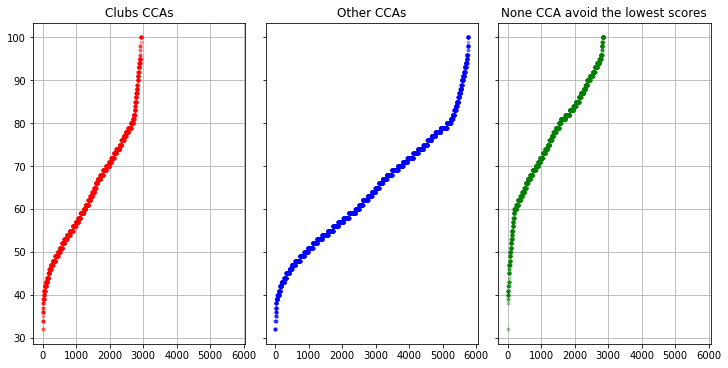

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(10,5), 
                         sharex=True, sharey=True, constrained_layout=True
                        )

ax = axes[0]
ax.set_title('Clubs CCAs')
def filterFn(row) :
    cca = row['CCA'].lower()
    return cca == 'clubs'
df_investigate = df_query[ df_query.apply(filterFn, axis=1)]
x = np.arange(len(df_investigate))
data = df_investigate['score'].sort_values()
ax.plot(x, data, 'r.', alpha=0.3,)
ax.grid()

ax = axes[1]
ax.set_title('Other CCAs')
def filterFn1(row) :
    cca = row['CCA'].lower()
    return (cca != 'none') and (cca != 'clubs')
df_investigate1 = df_query[ df_query.apply(filterFn1, axis=1)]
x1 = np.arange(len(df_investigate1))
axes[1].plot(x1, df_investigate1['score'].sort_values(), 'b.', alpha=0.3, )

ax = axes[2]
ax.set_title('None CCA avoid the lowest scores')
def filterFn2(row) :
    cca = row['CCA'].lower()
    return cca == 'none'
df_investigate2 = df_query[ df_query.apply(filterFn2, axis=1)]
x2 = np.arange(len(df_investigate2))
data = df_investigate2['score'].sort_values()
ax.plot(x2, data, 'g.', alpha=0.3,)
ax.grid()

printmd('*Hypothesis: Student who are in Clubs CCA will do better (because it includes Maths club).*')
printmd('False. However, students with no (core) CCA seem to avoid low scores.')

*Hypothesis: Student class size has an negative effect on math scores.*

True. Extremely small class sizes have higher class scores, and extremely large class sizes have lower class scores.

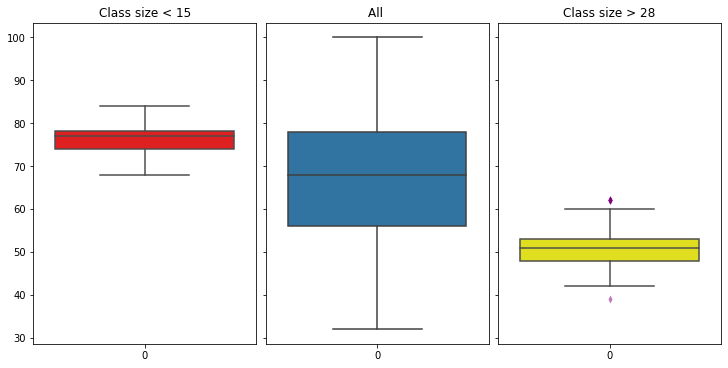

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(10,5), 
 sharex=True, sharey=True, constrained_layout=True
)

ax = axes[0]
ax.set_title('Class size < 15')
def filterFn(row) :
    class_size = row['n_male'] + row['n_female']
    return class_size < 15
df_investigate = df_query[ df_query.apply(filterFn, axis=1)]
data = df_investigate['score'].sort_values()
sns.boxplot(ax=axes[0], data=data.to_numpy(), color='red',
    flierprops=dict(markerfacecolor='purple', markeredgecolor='none', alpha=.3),
)

ax = axes[1]
ax.set_title('All ')
sns.boxplot(ax=axes[1], data=df_query['score'].to_numpy(), flierprops=dict(
    markerfacecolor='purple', markeredgecolor='none', alpha=.3
),)


ax = axes[2]
ax.set_title('Class size > 28')
def filterFn2(row) :
    class_size = row['n_male'] + row['n_female']
    return class_size > 28
df_investigate = df_query[ df_query.apply(filterFn2, axis=1)]
data = df_investigate['score'].sort_values()
sns.boxplot(ax=ax, data=data.to_numpy(), color='yellow',
    flierprops=dict(markerfacecolor='purple', markeredgecolor='none', alpha=.3),
)

printmd('*Hypothesis: Student class size has an negative effect on math scores.*')
printmd('True. Extremely small class sizes have higher class scores, and extremely large class sizes have lower class scores.')

*Hypothesis: Number of siblings, tuition, and mode of transport can be taken as proxies of economic status and therefore have an effect on class scores.*

True. Students with no siblings and tuition seem to do better than those with 2 siblings, no tuition and walk.

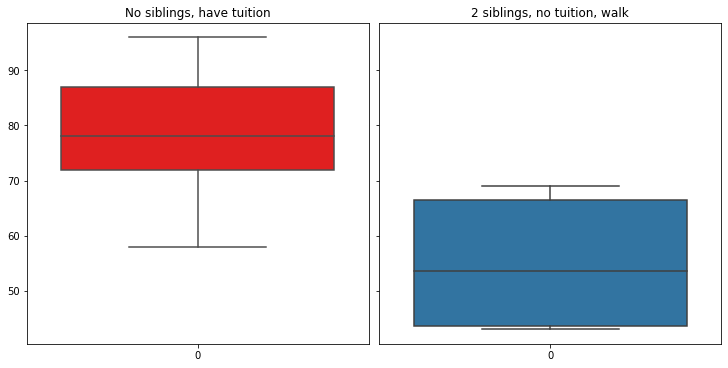

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5), 
     sharex=True, sharey=True, constrained_layout=True
)

ax = axes[0]
ax.set_title('No siblings, have tuition')
def filterFn(row) :
    return (row['number_of_siblings'] == 0) and (row['tuition'] == 'Y')
df_investigate = df_query[ df_query.apply(filterFn, axis=1)]
data = df_investigate['score']
sns.boxplot(ax=axes[0], data=data.to_numpy(), color='red',
    flierprops=dict(markerfacecolor='purple', markeredgecolor='none', alpha=.3),
)


ax=axes[1]
ax.set_title('2 siblings, no tuition, walk')
def filterFn2(row) :
    return (row['number_of_siblings'] == 2) and (row['tuition'] == 'N') and (row['mode_of_transport'] == 'walk') 
df_investigate2 = df_query[ df_query.apply(filterFn2, axis=1)]
sns.boxplot(ax=axes[1], data=df_investigate2['score'].to_numpy(), 
    flierprops=dict(markerfacecolor='purple', markeredgecolor='none', alpha=.3),)


df_query['mode_of_transport'].unique()
printmd('*Hypothesis: Number of siblings, tuition, and mode of transport can be taken as proxies of economic status and therefore have an effect on class scores.*')
printmd('True. Students with no siblings and tuition seem to do better than those with 2 siblings, no tuition and walk.')

At the end of step 5. Create Data Hypotheses and test them,  
There seems to be some features to be created
* Low attendance rate (<90%)
* Late sleeping time
* Class size
* Economic status proxy - based on number of siblings, tuition, and mode of transport


In [ ]:
df_result = pd.read_csv('./data/classification_predictions.csv')
df_result = df_result.sort_values('actual')

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm.png', facecolor='lightgray', bbox_inches='tight', pad_inches=0.5, )
    


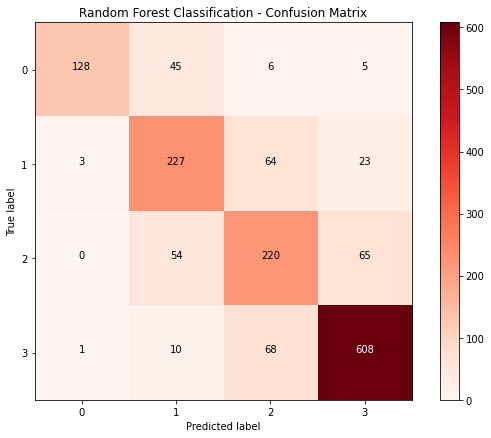

In [ ]:
from sklearn.metrics import confusion_matrix
labels=[0,1,2,3]
cm = confusion_matrix(df_result['actual'], df_result['random_forest_predicted'], labels = labels)


plot_confusion_matrix( confusion_matrix(df_result['actual'], df_result['random_forest_predicted'], labels = labels),
  target_names=[0,1,2,3],
  title='Random Forest Classification - Confusion Matrix',
  cmap=plt.get_cmap('Reds'),
  normalize=False)


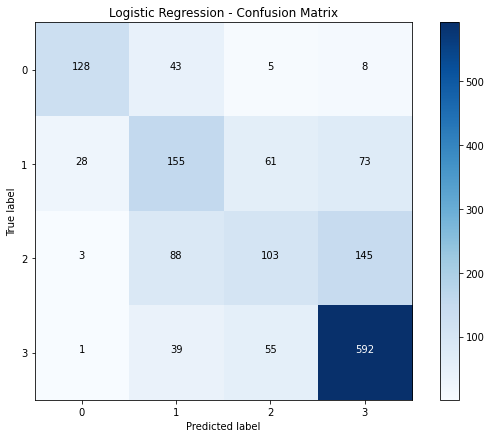

In [ ]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix( confusion_matrix(
    df_result['actual'], 
    df_result['logistic_regression_predicted'], 
    labels = [0,1,2,3]
  ),
  target_names=[0,1,2,3],
  title='Logistic Regression - Confusion Matrix',
  cmap=None,
  normalize=False)